In [89]:
import numpy as np

np.set_printoptions(precision=5, suppress=True)

def make_SE3(R, p):
    T = np.eye(4)
    T[:3,:3] = R
    T[:3, 3] = np.asarray(p, float)
    return T

def is_rotation_matrix(R, tol=1e-9):
    return np.allclose(R.T @ R, np.eye(3), atol=tol) and np.isclose(np.linalg.det(R), 1.0, atol=tol)

# --- HARD-CODE your rotation R_home directly ---
# Option 1: write it explicitly (columns are the EE's x,y,z axes expressed in {space}):
R_home = np.array([
    [ 0.0, 0.0,  1.0],   # x_e along world -y
    [ 0.0,  -1.0,  0.0],   # y_e along world +x
    [ 1.0,  0.0,  0.0],   # z_e along world +z
], dtype=float)

# sanity check (or set R_home = np.eye(3) if you want identity)
assert is_rotation_matrix(R_home), "R_home is not a valid rotation matrix!"

# 1) Geometry
L2 = 0.5          # meters — the ONLY defined link length (J2 -> J3)

# 2) Visual lift (optional, does NOT affect FK)
H_VIS = 0.0       # meters — purely for plotting aesthetics

# 3) Prismatic joint direction (expressed in the space frame at HOME)
#    Change this if your slider extends along a different axis at home.
PRISM_DIR_SPACE = np.array([1.0, 0.0, 0.0])  # +X by default
PRISM_DIR_SPACE = PRISM_DIR_SPACE / np.linalg.norm(PRISM_DIR_SPACE)

# Put the EE somewhere you like at home:
p_home = np.array([L2, 0.00, 0.00])   # meters (edit as needed)

# Pack M
M = make_SE3(R_home, p_home)

# --- Display for sanity ---
print("Constants:")
print("  L2 =", L2, "m")
print("  H_VIS (visual only) =", H_VIS, "m")
print("  PRISM_DIR_SPACE =", PRISM_DIR_SPACE)

print("\nHome EE pose M = [R|p]:")
print(M)
print("\nR_home (rows):\n", R_home)
print("p_home:", p_home)

Constants:
  L2 = 0.5 m
  H_VIS (visual only) = 0.0 m
  PRISM_DIR_SPACE = [1. 0. 0.]

Home EE pose M = [R|p]:
[[ 0.   0.   1.   0.5]
 [ 0.  -1.   0.   0. ]
 [ 1.   0.   0.   0. ]
 [ 0.   0.   0.   1. ]]

R_home (rows):
 [[ 0.  0.  1.]
 [ 0. -1.  0.]
 [ 1.  0.  0.]]
p_home: [0.5 0.  0. ]


In [90]:
# === 4 wi and 4 qi, unified screw build (J4 is "prismatic" via a linear term) ===
import numpy as np

# Axes directions at HOME (expressed in the space frame). Edit to match your robot.
w1 = np.array([0.0, 0.0, 1.0])   # J1 axis dir (unit)
w2 = np.array([0.0, -1.0, 0.0])   # J2 axis dir (unit)
w3 = np.array([0.0, -1.0, 0.0])   # J3 axis dir (unit)
w4 = np.array([0.0, 0.0, 0.0])   # J4: set w4 = 0; translation comes from v_lin below

# Points on each axis at HOME (space frame). Feel free to change q2/q3/q4 to match your layout.
q1 = np.array([0.0, 0.0, 0.0])
q2 = np.array([0.0, 0.0, 0.0])
q3 = np.array([L2 , 0.0, 0.0])   # put the J3 elbow at x=L2 at home
q4 = np.array([0.0 , 0.0, 0.0])   # prismatic anchor (bookkeeping; does not affect v when w=0)

# "Induced" linear parts (the only nonzero one is for the prismatic joint)
vlin1 = np.zeros(3)
vlin2 = np.zeros(3)
vlin3 = np.zeros(3)
vlin4 = PRISM_DIR_SPACE  # unit direction you set earlier

W    = np.vstack([w1, w2, w3, w4])     # shape (4,3)
Q    = np.vstack([q1, q2, q3, q4])     # shape (4,3)
VLIN = np.vstack([vlin1, vlin2, vlin3, vlin4])

# Unified formula: v = - w × q + v_lin  (row-wise)
V = -np.cross(W, Q) + VLIN             # numpy broadcasts cross row-wise
Slist = np.hstack([W, V])              # shape (4,6) — rows are [w | v] for J1..J4

print("Slist (rows J1..J4):\n", Slist)

Slist (rows J1..J4):
 [[ 0.   0.   1.   0.   0.   0. ]
 [ 0.  -1.   0.   0.   0.   0. ]
 [ 0.  -1.   0.   0.   0.  -0.5]
 [ 0.   0.   0.   1.   0.   0. ]]


In [91]:
# === Map each 6-vector screw to its 4x4 hat matrix, without 'skew' ===

def screw_hat(S):
    wx, wy, wz, vx, vy, vz = S
    return np.array([
        [   0, -wz,  wy, vx],
        [  wz,   0, -wx, vy],
        [ -wy,  wx,   0, vz],
        [   0,   0,   0,  0]
    ], float)

print("Hat matrices [S]^ (4x4) for each joint:")
for i, S in enumerate(Slist, 1):
    print(f"\n=== Joint {i} ===")
    print("S =", S)
    print(screw_hat(S))

Hat matrices [S]^ (4x4) for each joint:

=== Joint 1 ===
S = [0. 0. 1. 0. 0. 0.]
[[ 0. -1.  0.  0.]
 [ 1.  0. -0.  0.]
 [-0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]

=== Joint 2 ===
S = [ 0. -1.  0.  0.  0.  0.]
[[ 0. -0. -1.  0.]
 [ 0.  0. -0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]]

=== Joint 3 ===
S = [ 0.  -1.   0.   0.   0.  -0.5]
[[ 0.  -0.  -1.   0. ]
 [ 0.   0.  -0.   0. ]
 [ 1.   0.   0.  -0.5]
 [ 0.   0.   0.   0. ]]

=== Joint 4 ===
S = [0. 0. 0. 1. 0. 0.]
[[ 0. -0.  0.  1.]
 [ 0.  0. -0.  0.]
 [-0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]


In [92]:
# === PoE FK using hat matrices (closed-form exp on se(3)) ===
from math import sin, cos

def exp_se3_hat(Xi_hat, theta):
    """
    Exponential of se(3) element (4x4) times scalar theta, returned as a 4x4 in SE(3).
    Xi_hat is [[[w]x, v],
               [ 0 ,  0]]
    We detect w from the 3x3 block and apply closed-form.
    """
    # Extract w and v from Xi_hat (no skew helper)
    Wx = Xi_hat[0,1]; Wy = Xi_hat[2,0]; Wz = Xi_hat[1,2]  # these are NOT w components; careful!
    # It's safer to reconstruct w from the anti-symmetric part:
    W = Xi_hat[:3,:3]
    w = np.array([W[2,1], W[0,2], W[1,0]], float)  # because [w]_x = [[0,-wz, wy],[wz,0,-wx],[-wy,wx,0]]
    v = Xi_hat[:3,3]

    wn = np.linalg.norm(w)
    T = np.eye(4)

    if wn < 1e-12:
        # Pure translation
        T[:3,:3] = np.eye(3)
        T[:3, 3] = v * theta
        return T

    # Normalize axis
    w = w / wn
    wx, wy, wz = w

    # Build [w]_x and [w]_x^2 explicitly (no skew())
    wx_hat = np.array([
        [    0, -wz,  wy],
        [   wz,   0, -wx],
        [  -wy,  wx,   0]
    ], float)
    wx2 = wx_hat @ wx_hat

    # Rodrigues for R
    ct, st = cos(wn*theta), sin(wn*theta)   # but wn is 1 after normalization
    R = np.eye(3) + st*wx_hat + (1-ct)*wx2

    # V(theta) for the translational part: p = V v
    Vtheta = (np.eye(3)*theta
              + (1-ct)*wx_hat
              + (wn*theta - st)/wn * wx2)   # wn=1, but keep formula general

    p = Vtheta @ v

    T[:3,:3] = R
    T[:3, 3] = p
    return T

def poe_fk_from_hats(Slist, thetas, M):
    """T = (∏_i exp([S_i]^ θ_i)) M, using 4x4 hat matrices and exp_se3_hat."""
    T = np.eye(4)
    for S, th in zip(Slist, thetas):
        Xi_hat = screw_hat(S)
        T = T @ exp_se3_hat(Xi_hat, th)
    return T @ M

# ---- Try it: home and a sample configuration ----
theta_home = np.array([0.0, 0.0, 0.0, 0.0])         # [θ1, θ2, θ3, d4]
theta_test = np.array([0.4, -0.2, 0.3, 0.15])       # example (radians, meters)

T_home = poe_fk_from_hats(Slist, theta_home, M)
T_test = poe_fk_from_hats(Slist, theta_test, M)

print("\nT(home):\n", T_home)
print("\nT(test):\n", T_test)
print("\nEE position (test) [m]:", T_test[:3,3])


T(home):
 [[ 0.   0.   1.   0.5]
 [ 0.  -1.   0.   0. ]
 [ 1.   0.   0.   0. ]
 [ 0.   0.   0.   1. ]]

T(test):
 [[-0.09195  0.38942  0.91646  0.58882]
 [-0.03888 -0.92106  0.38747  0.24895]
 [ 0.995    0.       0.09983 -0.08436]
 [ 0.       0.       0.       1.     ]]

EE position (test) [m]: [ 0.58882  0.24895 -0.08436]


In [95]:
# === Utilities: joint origins and static overlay plot (color-coded) ===
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def joint_origins(Slist, thetas, M, H_vis=0.0):
    """
    Returns (N+2)x3:
      [base, J1, J2, ..., JN, EE]
    Joint i position = (prod_{k=1}^{i-1} exp([S_k]^ θ_k)) * q_i  (homogeneous).
    """
    N = Slist.shape[0]
    origins = [np.zeros(3)]              # base at world origin
    T = np.eye(4)

    # pre-store q_i (from the Slist build you just did)
    q_array = np.array([q1, q2, q3, q4])

    for i in range(N):
        # position of joint i (1-based) uses product up to i-1
        if i == 0:
            Ti_minus_1 = np.eye(4)
        else:
            Ti_minus_1 = np.eye(4)
            for k in range(i):
                Ti_minus_1 = Ti_minus_1 @ exp_se3_hat(screw_hat(Slist[k]), thetas[k])
        pi = (Ti_minus_1 @ np.r_[q_array[i], 1.0])[:3]
        origins.append(pi)

    # end-effector position
    T_full = np.eye(4)
    for k in range(N):
        T_full = T_full @ exp_se3_hat(screw_hat(Slist[k]), thetas[k])
    p_ee = (T_full @ M)[:3, 3]
    origins.append(p_ee)

    P = np.vstack(origins)
    if H_vis != 0.0:
        P = P.copy(); P[:,2] += H_vis
    return P

def _nice_bounds(PA, PB):
    all_pts = np.vstack([PA, PB])
    mins = all_pts.min(axis=0); maxs = all_pts.max(axis=0)
    ctr  = (mins + maxs) / 2.0
    span = float(np.max(maxs - mins))
    span = max(span, 0.5)
    lim  = span / 1.8
    return ctr, lim

# Labelled, color-coded initial vs final plot (interactive-friendly)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

def plot_initial_final(Slist, theta_init, theta_final, M, H_vis=0.0,
                       title="Initial (dashed) vs Final (solid) — color-coded links",
                       label_nodes=True, label_links=True):
    # --- get points ---
    P0 = joint_origins(Slist, theta_init, M, H_vis)
    Pf = joint_origins(Slist, theta_final, M, H_vis)

    N = Slist.shape[0]
    n_links = N + 1  # segments: base->J1, ..., JN->EE
    colors = plt.get_cmap("tab10").colors
    stroke = [pe.withStroke(linewidth=3.0, foreground="white")]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.set_title(title)
    ax.set_xlabel("X [m]"); ax.set_ylabel("Y [m]"); ax.set_zlabel("Z [m]")

    # bounds
    all_pts = np.vstack([P0, Pf])
    mins, maxs = all_pts.min(axis=0), all_pts.max(axis=0)
    ctr = (mins + maxs)/2.0
    span = float(np.max(maxs - mins))
    span = max(span, 0.5)
    lim  = span/1.8
    ax.set_xlim(ctr[0]-lim, ctr[0]+lim)
    ax.set_ylim(ctr[1]-lim, ctr[1]+lim)
    ax.set_zlim(ctr[2]-lim, ctr[2]+lim)

    # draw segments (initial dashed, final solid) and joint markers
    for i in range(n_links):
        c = colors[i % len(colors)]
        # initial
        ax.plot(P0[i:i+2,0], P0[i:i+2,1], P0[i:i+2,2],
                ls="--", lw=2, color=c, alpha=0.6)
        # final
        ax.plot(Pf[i:i+2,0], Pf[i:i+2,1], Pf[i:i+2,2],
                ls="-", lw=3, color=c, alpha=0.95)

    # joints (skip base at index 0)
    for j in range(1, N+1):
        c = colors[(j-1) % len(colors)]
        ax.scatter(P0[j,0], P0[j,1], P0[j,2], marker="x", s=55, color=c, alpha=0.8)
        ax.scatter(Pf[j,0], Pf[j,1], Pf[j,2], marker="o", s=60, edgecolor="k", color=c)

    # EE markers
    ax.scatter(P0[-1,0], P0[-1,1], P0[-1,2], marker="^", s=80, color="gray",  alpha=0.9, label="EE (init)")
    ax.scatter(Pf[-1,0], Pf[-1,1], Pf[-1,2], marker="^", s=90, edgecolor="k", color="black", alpha=0.95, label="EE (final)")

    # === Labels ===
    # A tiny offset so labels don't sit exactly on points (relative to plot span)
    off = 0.03 * span
    if label_nodes:
        # Base
        ax.text(Pf[0,0], Pf[0,1], Pf[0,2]+off, "Base",
                fontsize=10, ha="center", va="bottom", path_effects=stroke)
        # Joints J1..JN
        for j in range(1, N+1):
            c = colors[(j-1) % len(colors)]
            ax.text(Pf[j,0]+off, Pf[j,1]+off, Pf[j,2]+off,
                    f"J{j}", color=c, fontsize=10, weight="bold",
                    ha="left", va="bottom", path_effects=stroke)
        # EE
        ax.text(Pf[-1,0]+off, Pf[-1,1], Pf[-1,2]+off,
                "EE", fontsize=10, ha="left", va="bottom",
                path_effects=stroke)

    if label_links:
        # Links L1..L(n_links) labelled at midpoints of FINAL configuration
        for i in range(n_links):
            c = colors[i % len(colors)]
            mid = 0.5*(Pf[i] + Pf[i+1])
            ax.text(mid[0], mid[1], mid[2]+off,
                    f"L{i+1}", color=c, fontsize=10,
                    ha="center", va="bottom", path_effects=stroke)

    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))
    plt.tight_layout()
    plt.show()

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

def physical_points(theta, L2, M, H_vis=0.0):
    """
    Returns 3x3:
      [Base,
       Elbow (J3)  -> base pivot rotated by J1,J2 then +L2 along current x2,
       EE]         -> full PoE position (includes prismatic + tool offset in M)
    """
    # partial product up to joint 2
    T12 = np.eye(4)
    for k in range(2):  # J1, J2
        T12 = T12 @ exp_se3_hat(screw_hat(Slist[k]), theta[k])

    # elbow/J3 is L2 along current x2 from the base pivot
    elbow = (T12 @ np.array([L2, 0, 0, 1.0]))[:3]

    # full PoE for EE
    T = np.eye(4)
    for k in range(len(Slist)):
        T = T @ exp_se3_hat(screw_hat(Slist[k]), theta[k])
    ee = (T @ M)[:3, 3]

    P = np.vstack([np.zeros(3), elbow, ee])  # Base, Elbow(J3), EE
    if H_vis:
        P = P.copy(); P[:, 2] += H_vis
    return P

def plot_initial_final_physical(theta_init, theta_final, L2, M, H_vis=0.0,
                                title="Initial (dashed) vs Final (solid) — physical links"):
    P0 = physical_points(theta_init, L2, M, H_vis)
    Pf = physical_points(theta_final, L2, M, H_vis)

    colors = ["tab:green", "tab:purple"]  # L2 bar, prismatic slider
    stroke = [pe.withStroke(linewidth=3, foreground="white")]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.set_title(title)
    ax.set_xlabel("X [m]"); ax.set_ylabel("Y [m]"); ax.set_zlabel("Z [m]")

    # bounds
    all_pts = np.vstack([P0, Pf])
    mins, maxs = all_pts.min(axis=0), all_pts.max(axis=0)
    ctr = (mins + maxs) / 2.0
    span = float(np.max(maxs - mins))
    span = max(span, 0.5)
    lim  = span / 1.8
    ax.set_xlim(ctr[0]-lim, ctr[0]+lim)
    ax.set_ylim(ctr[1]-lim, ctr[1]+lim)
    ax.set_zlim(ctr[2]-lim, ctr[2]+lim)

    # draw only 2 physical segments: Base->Elbow (L2), Elbow->EE (slider)
    # initial (dashed)
    ax.plot(P0[0:2,0], P0[0:2,1], P0[0:2,2], ls="--", lw=2, color=colors[0], alpha=0.7)  # L2
    ax.plot(P0[1:3,0], P0[1:3,1], P0[1:3,2], ls="--", lw=2, color=colors[1], alpha=0.7)  # slider
    # final (solid)
    ax.plot(Pf[0:2,0], Pf[0:2,1], Pf[0:2,2], ls="-", lw=3, color=colors[0], alpha=0.95)
    ax.plot(Pf[1:3,0], Pf[1:3,1], Pf[1:3,2], ls="-", lw=3, color=colors[1], alpha=0.95)

    # markers
    ax.scatter(P0[0,0], P0[0,1], P0[0,2], marker="x", s=55, color="tab:orange", alpha=0.9)  # Base init
    ax.scatter(Pf[0,0], Pf[0,1], Pf[0,2], marker="o", s=60, edgecolor="k", color="tab:orange")  # Base final
    ax.scatter(P0[1,0], P0[1,1], P0[1,2], marker="x", s=55, color="tab:green", alpha=0.9)   # Elbow init
    ax.scatter(Pf[1,0], Pf[1,1], Pf[1,2], marker="o", s=60, edgecolor="k", color="tab:green")   # Elbow final
    ax.scatter(P0[2,0], P0[2,1], P0[2,2], marker="^", s=80, color="gray", alpha=0.9, label="EE (init)")
    ax.scatter(Pf[2,0], Pf[2,1], Pf[2,2], marker="^", s=90, edgecolor="k", color="black", alpha=0.95, label="EE (final)")

    # labels near FINAL pose
    off = 0.03 * span
    ax.text(Pf[0,0], Pf[0,1], Pf[0,2]+off, "Base", fontsize=10, path_effects=stroke)
    ax.text(Pf[1,0]+off, Pf[1,1]+off, Pf[1,2]+off, "J3 (Elbow)", color="tab:green",
            fontsize=10, weight="bold", path_effects=stroke)
    ax.text(Pf[2,0]+off, Pf[2,1], Pf[2,2]+off, "EE", fontsize=10, path_effects=stroke)

    # link labels at midpoints (final)
    mid_L2 = 0.5*(Pf[0] + Pf[1])
    mid_P  = 0.5*(Pf[1] + Pf[2])
    ax.text(mid_L2[0], mid_L2[1], mid_L2[2]+off, "L2", color=colors[0], fontsize=10, path_effects=stroke)
    ax.text(mid_P[0],  mid_P[1],  mid_P[2]+off,  "Prismatic", color=colors[1], fontsize=10, path_effects=stroke)

    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1))
    plt.tight_layout()
    plt.show()

T(final):
 [[-0.32336  0.84147 -0.43286 -0.07047]
 [-0.5036  -0.5403  -0.67414 -0.10975]
 [-0.80114  0.       0.59847  0.71997]
 [ 0.       0.       0.       1.     ]]
EE position (final) [m]: [-0.07047 -0.10975  0.71997]


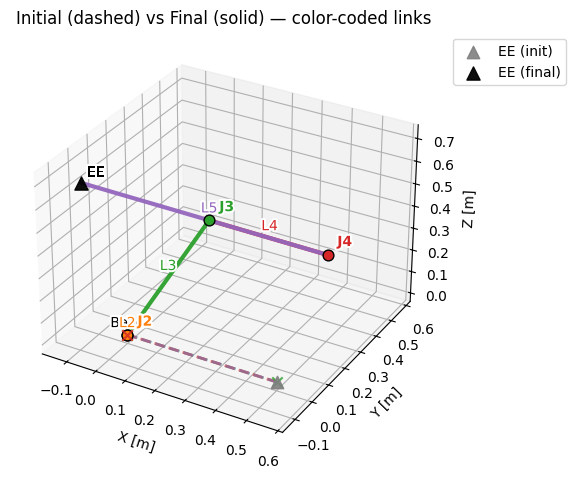

In [97]:
# === Example: choose initial and final, then plot ===

theta_init  = np.array([0.0, 0.0, 0.0, 0.0])         # [θ1, θ2, θ3, d4]
theta_final = np.array([1.0, 1.0, 1.5, 0.5])      # radians, radians, radians, meters

# Show the final pose numerically too (optional)
T_final = poe_fk_from_hats(Slist, theta_final, M)
print("T(final):\n", T_final)
print("EE position (final) [m]:", T_final[:3,3])

# Plot color-coded initial vs final
plot_initial_final(Slist, theta_init, theta_final, M, H_vis=H_VIS,
                   title="Initial (dashed) vs Final (solid) — color-coded links")

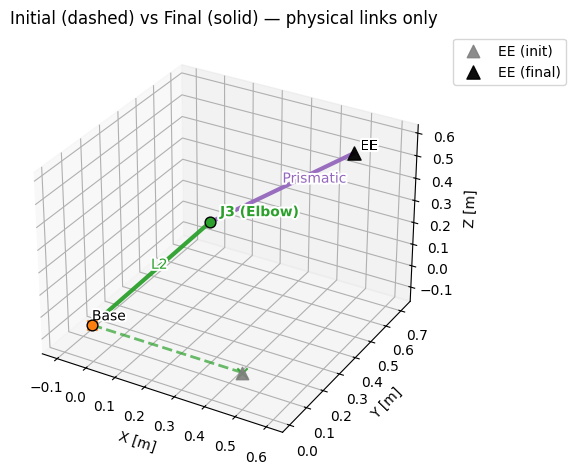

In [101]:
# Optional for rotation/zoom:
# %matplotlib notebook   # or: %matplotlib widget (pip install ipympl)

theta_init  = np.array([0.0, 0.0, 0.0, 0.00])   # [θ1, θ2, θ3, d4]
theta_final = np.array([1.0, 0.7, -0.4, 0.50])  # last entry = prismatic (m)

plot_initial_final_physical(theta_init, theta_final, L2=L2, M=M, H_vis=H_VIS,
                            title="Initial (dashed) vs Final (solid) — physical links only")

In [102]:
# === Animation: physical links only (Base->L2->Prismatic) ===
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Video, Image, display

# If matplotlib can’t find ffmpeg on macOS Homebrew, you can point to it:
# import matplotlib as mpl
# mpl.rcParams['animation.ffmpeg_path'] = "/opt/homebrew/bin/ffmpeg"

def time_scaling_cubic(t, T):
    tau = np.clip(t / T, 0.0, 1.0)
    return 3*tau**2 - 2*tau**3

def animate_physical(theta_init, theta_final, L2, M, H_vis=0.0,
                     T_total=4.0, fps=30, filename="arm_transition.mp4",
                     show_preview=False):
    """
    Save an animation of the physical links transitioning from theta_init to theta_final.
    - theta_init/final: [θ1, θ2, θ3, d4]
    - L2: single bar length
    - M: home EE pose
    - H_vis: visual z-lift (doesn't affect FK)
    """
    ts = np.linspace(0, T_total, int(T_total*fps) + 1)
    thetas = np.array([theta_init + time_scaling_cubic(t, T_total)*(theta_final - theta_init) for t in ts])

    # Precompute endpoints for axis limits
    P0 = physical_points(theta_init, L2, M, H_vis)
    Pf = physical_points(theta_final, L2, M, H_vis)
    all_pts = np.vstack([P0, Pf])
    mins, maxs = all_pts.min(axis=0), all_pts.max(axis=0)
    ctr = (mins + maxs) / 2.0
    span = float(np.max(maxs - mins))
    span = max(span, 0.5)
    lim  = span / 1.8

    # Figure/axes
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.set_title("3R+P — physical links animation")
    ax.set_xlabel("X [m]"); ax.set_ylabel("Y [m]"); ax.set_zlabel("Z [m]")
    ax.set_xlim(ctr[0]-lim, ctr[0]+lim)
    ax.set_ylim(ctr[1]-lim, ctr[1]+lim)
    ax.set_zlim(ctr[2]-lim, ctr[2]+lim)

    # Artists: two segments (L2 in green, prismatic in purple) + three markers
    (seg_L2,) = ax.plot([], [], [], lw=3, color="tab:green")
    (seg_P ,) = ax.plot([], [], [], lw=3, color="tab:purple")
    base_pt   = ax.scatter([], [], [], marker="o", s=60, edgecolor="k", color="tab:orange")
    elbow_pt  = ax.scatter([], [], [], marker="o", s=60, edgecolor="k", color="tab:green")
    ee_pt     = ax.scatter([], [], [], marker="^", s=90, edgecolor="k", color="black")

    def update(k):
        P = physical_points(thetas[k], L2, M, H_vis)  # shape (3,3): [Base, Elbow, EE]
        # segments
        seg_L2.set_data(P[0:2,0], P[0:2,1]); seg_L2.set_3d_properties(P[0:2,2])
        seg_P .set_data(P[1:3,0], P[1:3,1]); seg_P .set_3d_properties(P[1:3,2])
        # markers
        base_pt._offsets3d  = (np.r_[P[0,0]], np.r_[P[0,1]], np.r_[P[0,2]])
        elbow_pt._offsets3d = (np.r_[P[1,0]], np.r_[P[1,1]], np.r_[P[1,2]])
        ee_pt._offsets3d    = (np.r_[P[2,0]], np.r_[P[2,1]], np.r_[P[2,2]])
        return seg_L2, seg_P, base_pt, elbow_pt, ee_pt

    frames = len(ts)
    saved_path = None

    if animation.writers.is_available("ffmpeg"):
        writer = animation.FFMpegWriter(fps=fps, bitrate=1800)
        with writer.saving(fig, filename, dpi=120):
            for k in range(frames):
                update(k); writer.grab_frame()
        saved_path = filename
        print(f"Saved MP4 -> {saved_path}")
        display(Video(saved_path, embed=True, html_attributes="controls loop"))
    else:
        # fallback to GIF (needs pillow)
        try:
            gif_name = filename.replace(".mp4", ".gif")
            from matplotlib.animation import PillowWriter
            writer = PillowWriter(fps=fps)
            with writer.saving(fig, gif_name, dpi=120):
                for k in range(frames):
                    update(k); writer.grab_frame()
            saved_path = gif_name
            print(f"`ffmpeg` not found; saved GIF -> {saved_path}")
            display(Image(filename=saved_path))
        except Exception as e:
            print("No writer available. Install `ffmpeg` (MP4) or `pillow` (GIF). Error:", e)
            show_preview = True

    if show_preview:
        # crude live preview
        for k in range(frames):
            update(k); plt.pause(0.001)
        plt.show()

    return saved_path

Saved MP4 -> arm_transition.mp4


'arm_transition.mp4'

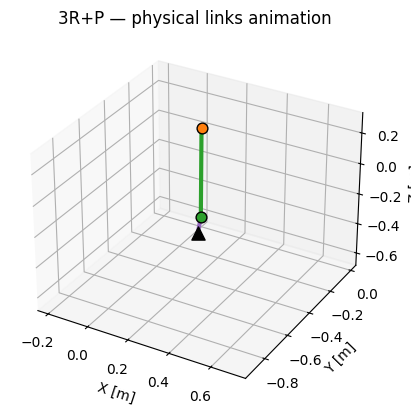

In [108]:
theta_init  = np.array([0.0, 0.0, 0.0, 0.00])   # [θ1, θ2, θ3, d4]
theta_final = np.array([200.0, 24.0, 8.0, 1.0])  # final (radians, radians, radians, meters)

animate_physical(theta_init, theta_final, L2=L2, M=M, H_vis=H_VIS,
                 T_total=4.0, fps=30, filename="arm_transition.mp4")